In [1]:
!pip install gdown
import gdown
import zipfile
file_id = "1znqUeFzYz-DeAE3dYXD17qoMPK82Whji"
output = "dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet = False)

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
  zip_ref.extractall("/content/dataset")

Downloading...
From (original): https://drive.google.com/uc?id=1znqUeFzYz-DeAE3dYXD17qoMPK82Whji
From (redirected): https://drive.google.com/uc?id=1znqUeFzYz-DeAE3dYXD17qoMPK82Whji&confirm=t&uuid=f0fa73e3-ca2a-411b-8b24-c595996bde5b
To: /content/dataset.zip
100%|██████████| 2.89G/2.89G [00:25<00:00, 114MB/s] 


In [2]:
file_id = "1uJmDZw649XS-r-dYs9WD-OPwF_TIroVw"
output = "datasetResolution.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

with zipfile.ZipFile(output, "r") as zip_ref:
    zip_ref.extractall("/content/datasetResolution")

Downloading...
From (original): https://drive.google.com/uc?id=1uJmDZw649XS-r-dYs9WD-OPwF_TIroVw
From (redirected): https://drive.google.com/uc?id=1uJmDZw649XS-r-dYs9WD-OPwF_TIroVw&confirm=t&uuid=f3ae6172-60e7-4eab-a091-9a43f9a4ee18
To: /content/datasetResolution.zip
100%|██████████| 533M/533M [00:06<00:00, 84.7MB/s]


In [3]:
import os
import numpy as np

axion_dir = "/content/dataset/Dataset/axion"
fixed_axion_dir = "/content/dataset/Dataset/axion_fixed"

os.makedirs(fixed_axion_dir, exist_ok=True)

for filename in os.listdir(axion_dir):
    if filename.endswith(".npy"):
        file_path = os.path.join(axion_dir, filename)

        arr = np.load(file_path, allow_pickle=True)

        # The arr is shape (2,) and arr[0] is the (64,64) data:
        if arr.shape == (2,) and isinstance(arr[0], np.ndarray):
            fixed_array = arr[0]
        else:
            # If it doesn't match the expected pattern, decide how to handle it.
            # Possibly skip or handle differently.
            fixed_array = arr

        # Re-save the fixed array so it is directly (64,64)
        np.save(os.path.join(fixed_axion_dir, filename), fixed_array)

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from skimage.metrics import structural_similarity as ssim
import math
from sklearn.preprocessing import label_binarize

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
pretrain_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [7]:
class MAEDataset(Dataset):
    def __init__(self, file_paths, mask_ratio=0.85, patch_size=8, transform=None):
        self.file_paths = file_paths
        self.mask_ratio = mask_ratio
        self.patch_size = patch_size
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = np.load(self.file_paths[idx])
        img = torch.tensor(img, dtype=torch.float32)
        # Adding channel dimension if needed
        if img.ndim == 2:
            img = img.unsqueeze(0)
        if self.transform:
            img = self.transform(img)
        # Creating a masked version of the image.
        masked_img, mask = self.apply_mask(img)
        return masked_img, img, mask

    def apply_mask(self, img):
        C, H, W = img.shape
        patch_size = self.patch_size
        n_patches_h = H // patch_size
        n_patches_w = W // patch_size
        total_patches = n_patches_h * n_patches_w
        num_mask = int(total_patches * self.mask_ratio)
        mask_indices = np.random.choice(total_patches, num_mask, replace=False)
        mask = torch.zeros((n_patches_h, n_patches_w))
        mask.view(-1)[mask_indices] = 1.0  # 1 indicates the patch is masked
        # Create a copy of the image and zero-out masked patches.
        masked_img = img.clone()
        for i in range(n_patches_h):
            for j in range(n_patches_w):
                if mask[i, j] == 1:
                    masked_img[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = 0.0
        return masked_img, mask

In [8]:
class ClassificationDataset(Dataset):
    def __init__(self, data_path, classes, transform=None):
        self.samples = []
        for i, cls in enumerate(classes):
            for path in data_path[cls]:
                self.samples.append((path, i))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = np.load(path)
        img = torch.tensor(img, dtype=torch.float32)
        if img.ndim == 2:
            img = img.unsqueeze(0)
        if self.transform:
            img = self.transform(img)
        return img, label

In [9]:
class SRDataset(Dataset):
    def __init__(self, lr_paths, hr_paths, transform=None):
        self.lr_paths = lr_paths
        self.hr_paths = hr_paths
        self.transform = transform

    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        lr = np.load(self.lr_paths[idx])
        hr = np.load(self.hr_paths[idx])
        lr = torch.tensor(lr, dtype=torch.float32)
        hr = torch.tensor(hr, dtype=torch.float32)
        if lr.ndim == 2:
            lr = lr.unsqueeze(0)
        if hr.ndim == 2:
            hr = hr.unsqueeze(0)
        if self.transform:
            lr = self.transform(lr)
            hr = self.transform(hr)
        return lr, hr

In [10]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_se=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.act2 = nn.LeakyReLU(inplace=True)
        self.se = SEBlock(out_channels) if use_se else None
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.se is not None:
            out = self.se(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.act2(out)
        return out

In [12]:
class MAE(nn.Module):
    def __init__(self):
        super(MAE, self).__init__()
        self.encoder = nn.Sequential(
            ResidualBlock(1, 32, stride=2, use_se=True),
            ResidualBlock(32, 64, stride=2, use_se=True),
            ResidualBlock(64, 128, stride=2, use_se=True),
            ResidualBlock(128, 256, stride=2, use_se=True)
        )
        # Decoder with extra residual blocks to increase capacity
        self.dc1_up = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dc1 = nn.Sequential(
            ResidualBlock(128 + 128, 128, stride=1, use_se=True),
            ResidualBlock(128, 128, stride=1, use_se=True)  # extra block
        )
        self.dc2_up = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dc2 = nn.Sequential(
            ResidualBlock(64 + 64, 64, stride=1, use_se=True),
            ResidualBlock(64, 64, stride=1, use_se=True)  # extra block
        )
        self.dc3_up = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dc3 = nn.Sequential(
            ResidualBlock(32 + 32, 32, stride=1, use_se=True),
            ResidualBlock(32, 32, stride=1, use_se=True)  # extra block
        )
        self.dc4_up = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dc4_conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        e1 = self.encoder[0](x)
        e2 = self.encoder[1](e1)
        e3 = self.encoder[2](e2)
        e4 = self.encoder[3](e3)
        d1_up = self.dc1_up(e4)
        d1_concat = torch.cat([d1_up, e3], dim=1)
        d1 = self.dc1(d1_concat)
        d2_up = self.dc2_up(d1)
        d2_concat = torch.cat([d2_up, e2], dim=1)
        d2 = self.dc2(d2_concat)
        d3_up = self.dc3_up(d2)
        d3_concat = torch.cat([d3_up, e1], dim=1)
        d3 = self.dc3(d3_concat)
        d4_up = self.dc4_up(d3)
        out = self.dc4_conv(d4_up)
        return out, e4

In [13]:
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=3, latent_dim=256, dropout_rate=0.5, use_transformer=False):

        super(Classifier, self).__init__()
        self.encoder = encoder
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.use_transformer = use_transformer
        if use_transformer:
            # Lightweight transformer encoder head.
            encoder_layer = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=8, dropout=dropout_rate)
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        # MLP classifier head with dropout.
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, latent_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(latent_dim // 2, num_classes)
        )

    def forward(self, x):
        latent = self.encoder(x)
        x = self.pool(latent)
        x = torch.flatten(x, 1)
        if self.use_transformer:
            # Transformer expects a sequence dimension.
            x = x.unsqueeze(1)
            x = self.transformer(x)
            x = x.squeeze(1)
        logits = self.mlp(x)
        return logits

In [14]:
class CustomEncoder(nn.Module):
    def __init__(self, pretrained_mae):
        super(CustomEncoder, self).__init__()
        self.encoder = nn.Sequential(
            pretrained_mae.encoder[0],
            pretrained_mae.encoder[1]
        )
    def forward(self, x):
        return self.encoder(x)

In [15]:
class SRDecoderModified(nn.Module):
    def __init__(self, in_channels=64, target_size=(150, 150)):
        super(SRDecoderModified, self).__init__()
        self.target_size = target_size
        self.up1 = nn.ConvTranspose2d(in_channels, 32, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.act = nn.LeakyReLU(inplace=True)
        self.up2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.up3 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(8, 1, kernel_size=3, padding=1)
        self.final_act = nn.Sigmoid()

    def forward(self, x):
        x = self.up1(x)
        x = self.conv1(x)
        x = self.act(x)
        x = self.up2(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.up3(x)
        x = self.conv3(x)
        if x.shape[2:] != self.target_size:
            diff_h = x.shape[2] - self.target_size[0]
            diff_w = x.shape[3] - self.target_size[1]
            x = x[:, :, diff_h//2:diff_h//2+self.target_size[0], diff_w//2:diff_w//2+self.target_size[1]]
        x = self.final_act(x)
        return x

In [16]:
class SRModel(nn.Module):
    def __init__(self, pretrained_encoder, target_size=(150, 150)):
        super(SRModel, self).__init__()
        self.encoder = pretrained_encoder
        self.decoder = SRDecoderModified(in_channels=64, target_size=target_size)

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out

In [17]:
def train_mae(model, dataloader, optimizer, scheduler, device, scaler, epochs=10):
    model.train()
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        epoch_loss = 0.0
        pbar = tqdm(dataloader, desc=f"[MAE Pre-training] Epoch {epoch+1}/{epochs}")
        for masked_img, img, _ in pbar:
            masked_img = masked_img.to(device)
            img = img.to(device)
            optimizer.zero_grad()
            with autocast():
                recon, _ = model(masked_img)
                loss = criterion(recon, img)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item() * masked_img.size(0)
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        scheduler.step()
        print(f"[MAE Pre-training] Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss/len(dataloader.dataset):.4f}")

In [18]:
def train_classifier(model, dataloader, optimizer, scheduler, device, scaler, class_weights=None, epochs=10):
    model.train()
    # Use class weights in the loss if provided.
    criterion = nn.CrossEntropyLoss(weight=class_weights) if class_weights is not None else nn.CrossEntropyLoss()
    for epoch in range(epochs):
        epoch_loss = 0.0
        pbar = tqdm(dataloader, desc=f"[Classifier Fine-tuning] Epoch {epoch+1}/{epochs}")
        for imgs, labels in pbar:
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with autocast():
                logits = model(imgs)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item() * imgs.size(0)
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        # For ReduceLROnPlateau, the step is called with the validation loss.
        scheduler.step(epoch_loss/len(dataloader.dataset))
        print(f"[Classifier Fine-tuning] Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss/len(dataloader.dataset):.4f}")

In [19]:
def train_sr(model, dataloader, optimizer, device, scaler, epochs=10):
    model.train()
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        epoch_loss = 0.0
        pbar = tqdm(dataloader, desc=f"SR Training Epoch {epoch+1}/{epochs}")
        for lr, hr in pbar:
            lr = lr.to(device)
            hr = hr.to(device)
            optimizer.zero_grad()
            with autocast():
                sr = model(lr)
                loss = criterion(sr, hr)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item() * lr.size(0)
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        print(f"Epoch {epoch+1}/{epochs}, SR Loss: {epoch_loss/len(dataloader.dataset):.4f}")

In [35]:
def evaluate_classifier(model, dataloader, num_classes=3):
    model.eval()
    all_labels, all_probs = [], []
    criterion = nn.CrossEntropyLoss()
    val_loss = 0.0

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)

            loss = criterion(logits, labels)
            val_loss += loss.item() * imgs.size(0)

            probs = torch.softmax(logits, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss /= len(dataloader.dataset)
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    y_true = label_binarize(all_labels, classes=list(range(num_classes)))
    aucs = []

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

    return val_loss, np.mean(aucs)

In [21]:
def evaluate_sr(model, dataloader, device):
    model.eval()
    mse_loss = 0.0
    psnr_total = 0.0
    ssim_total = 0.0
    criterion = nn.MSELoss(reduction='mean')
    n = 0
    with torch.no_grad():
        for lr, hr in tqdm(dataloader, desc="Evaluating SR", leave=False):
            lr = lr.to(device)
            hr = hr.to(device)
            sr = model(lr)
            mse = criterion(sr, hr).item()
            mse_loss += mse * lr.size(0)
            # Compute PSNR (assuming pixel values in [0,1])
            psnr_val = 10 * math.log10(1.0 / mse) if mse > 0 else 100
            psnr_total += psnr_val * lr.size(0)
            # Compute SSIM for each image (convert tensors to numpy arrays)
            sr_np = sr.cpu().numpy()
            hr_np = hr.cpu().numpy()
            for i in range(sr_np.shape[0]):
                # Assuming single channel images
                ssim_val = ssim(hr_np[i, 0], sr_np[i, 0], data_range=hr_np[i,0].max()-hr_np[i,0].min())
                ssim_total += ssim_val
                n += 1
    mse_avg = mse_loss / len(dataloader.dataset)
    psnr_avg = psnr_total / len(dataloader.dataset)
    ssim_avg = ssim_total / n
    print(f"SR Evaluation - MSE: {mse_avg:.4f}, PSNR: {psnr_avg:.2f}, SSIM: {ssim_avg:.4f}")

In [22]:
def compare_hr_sr(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for lr, hr in dataloader:
            lr = lr.to(device)
            hr = hr.to(device)
            sr = model(lr)
            for i in range(hr.shape[0]):
                hr_np = hr[i].cpu().numpy().squeeze(0)
                sr_np = sr[i].cpu().numpy().squeeze(0)
                ssim_score = ssim(hr_np, sr_np, data_range=hr_np.max()-hr_np.min())
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                axes[0].imshow(hr_np, cmap='gray')
                axes[0].set_title('Original HR')
                axes[0].axis('off')
                axes[1].imshow(sr_np, cmap='gray')
                axes[1].set_title(f'Super-Resolved (SSIM: {ssim_score:.4f})')
                axes[1].axis('off')
                plt.show()
            break

In [23]:
base_path_for_6A = "/content/dataset/Dataset"
classes = ['no_sub', 'cdm', 'axion_fixed']
data_paths = {
    cls: [os.path.join(base_path_for_6A, cls, f)
    for f in os.listdir(os.path.join(base_path_for_6A, cls)) if f.endswith('.npy')]
    for cls in classes
}

In [24]:
batch_size = 32
pretrain_epochs = 10
lr_pretrain = 1e-3

In [25]:
no_sub_paths = data_paths['no_sub']
pretrain_dataset = MAEDataset(no_sub_paths, mask_ratio=0.75, patch_size=8, transform=pretrain_transform)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [26]:
modelMAE = MAE().to(device)
optimizer_mae = optim.Adam(modelMAE.parameters(), lr=lr_pretrain)
scheduler_mae = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_mae, T_max=pretrain_epochs)
scaler = GradScaler()

<ipython-input-26-75b647956cc8>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
print("Starting MAE pre-training...")
train_mae(modelMAE, pretrain_loader, optimizer_mae, scheduler_mae, device, scaler, epochs=pretrain_epochs)

Starting MAE pre-training...


[MAE Pre-training] Epoch 1/10:   0%|          | 0/921 [00:00<?, ?it/s]<ipython-input-17-6dde00bad2cb>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[MAE Pre-training] Epoch 1/10: 100%|██████████| 921/921 [01:28<00:00, 10.44it/s, loss=0.0621]


[MAE Pre-training] Epoch [1/10] Loss: 0.0628


[MAE Pre-training] Epoch 2/10: 100%|██████████| 921/921 [01:17<00:00, 11.86it/s, loss=0.0508]


[MAE Pre-training] Epoch [2/10] Loss: 0.0579


[MAE Pre-training] Epoch 3/10: 100%|██████████| 921/921 [01:18<00:00, 11.75it/s, loss=0.0693]


[MAE Pre-training] Epoch [3/10] Loss: 0.0577


[MAE Pre-training] Epoch 4/10: 100%|██████████| 921/921 [01:17<00:00, 11.81it/s, loss=0.0770]


[MAE Pre-training] Epoch [4/10] Loss: 0.0576


[MAE Pre-training] Epoch 5/10: 100%|██████████| 921/921 [01:17<00:00, 11.82it/s, loss=0.0676]


[MAE Pre-training] Epoch [5/10] Loss: 0.0575


[MAE Pre-training] Epoch 6/10: 100%|██████████| 921/921 [01:18<00:00, 11.78it/s, loss=0.0652]


[MAE Pre-training] Epoch [6/10] Loss: 0.0575


[MAE Pre-training] Epoch 7/10: 100%|██████████| 921/921 [01:18<00:00, 11.80it/s, loss=0.0389]


[MAE Pre-training] Epoch [7/10] Loss: 0.0574


[MAE Pre-training] Epoch 8/10: 100%|██████████| 921/921 [01:18<00:00, 11.81it/s, loss=0.0610]


[MAE Pre-training] Epoch [8/10] Loss: 0.0574


[MAE Pre-training] Epoch 9/10: 100%|██████████| 921/921 [01:18<00:00, 11.76it/s, loss=0.0489]


[MAE Pre-training] Epoch [9/10] Loss: 0.0574


[MAE Pre-training] Epoch 10/10:  79%|███████▉  | 730/921 [01:01<00:15, 12.59it/s, loss=0.0482]

In [ ]:
torch.save(modelMAE.state_dict(), 'pretrained_mae_weights.pth')

In [ ]:
class_dataset_train = ClassificationDataset(data_paths, classes, transform=train_transform)
class_dataset_val = ClassificationDataset(data_paths, classes, transform=None)

train_size = int(0.8 * len(class_dataset_train))
val_size = len(class_dataset_train) - train_size
train_dataset, val_dataset = random_split(class_dataset_train, [train_size, val_size])

train_loader_cls = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_cls = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [30]:
modelMAE.load_state_dict(torch.load('pretrained_mae_weights.pth'))
encoder_for_classifier = modelMAE.encoder

In [31]:
classifier_model = Classifier(encoder=encoder_for_classifier, num_classes=3, latent_dim=256, dropout_rate=0.5, use_transformer=False).to(device)

In [32]:
lr_cls = 1e-3
optimizer_cls = optim.AdamW(classifier_model.parameters(), lr=lr_cls)
scheduler_cls = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_cls, mode='min', factor=0.5, patience=2)
scaler_cls = GradScaler()

<ipython-input-32-275e89f6c422>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_cls = GradScaler()


In [34]:
print("Starting classifier fine-tuning...")
train_classifier(classifier_model, train_loader_cls, optimizer_cls, scheduler_cls, device, scaler_cls, class_weights=None, epochs=10)

Starting classifier fine-tuning...


[Classifier Fine-tuning] Epoch 1/10:   0%|          | 0/2228 [00:00<?, ?it/s]<ipython-input-18-08ef73169760>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[Classifier Fine-tuning] Epoch 1/10: 100%|██████████| 2228/2228 [01:10<00:00, 31.73it/s, loss=0.0620]


[Classifier Fine-tuning] Epoch [1/10] Loss: 0.2809


[Classifier Fine-tuning] Epoch 2/10: 100%|██████████| 2228/2228 [00:59<00:00, 37.15it/s, loss=0.0335]


[Classifier Fine-tuning] Epoch [2/10] Loss: 0.0795


[Classifier Fine-tuning] Epoch 3/10: 100%|██████████| 2228/2228 [00:56<00:00, 39.66it/s, loss=0.0410]


[Classifier Fine-tuning] Epoch [3/10] Loss: 0.0634


[Classifier Fine-tuning] Epoch 4/10: 100%|██████████| 2228/2228 [01:00<00:00, 36.53it/s, loss=0.0679]


[Classifier Fine-tuning] Epoch [4/10] Loss: 0.0500


[Classifier Fine-tuning] Epoch 5/10: 100%|██████████| 2228/2228 [01:07<00:00, 32.79it/s, loss=0.0026]


[Classifier Fine-tuning] Epoch [5/10] Loss: 0.0488


[Classifier Fine-tuning] Epoch 6/10: 100%|██████████| 2228/2228 [01:00<00:00, 36.84it/s, loss=0.0987]


[Classifier Fine-tuning] Epoch [6/10] Loss: 0.0414


[Classifier Fine-tuning] Epoch 7/10: 100%|██████████| 2228/2228 [00:55<00:00, 39.85it/s, loss=0.0134]


[Classifier Fine-tuning] Epoch [7/10] Loss: 0.0390


[Classifier Fine-tuning] Epoch 8/10: 100%|██████████| 2228/2228 [00:57<00:00, 38.72it/s, loss=0.0158]


[Classifier Fine-tuning] Epoch [8/10] Loss: 0.0363


[Classifier Fine-tuning] Epoch 9/10: 100%|██████████| 2228/2228 [00:58<00:00, 37.97it/s, loss=0.0001]


[Classifier Fine-tuning] Epoch [9/10] Loss: 0.0315


[Classifier Fine-tuning] Epoch 10/10: 100%|██████████| 2228/2228 [00:56<00:00, 39.44it/s, loss=0.0002]

[Classifier Fine-tuning] Epoch [10/10] Loss: 0.0317


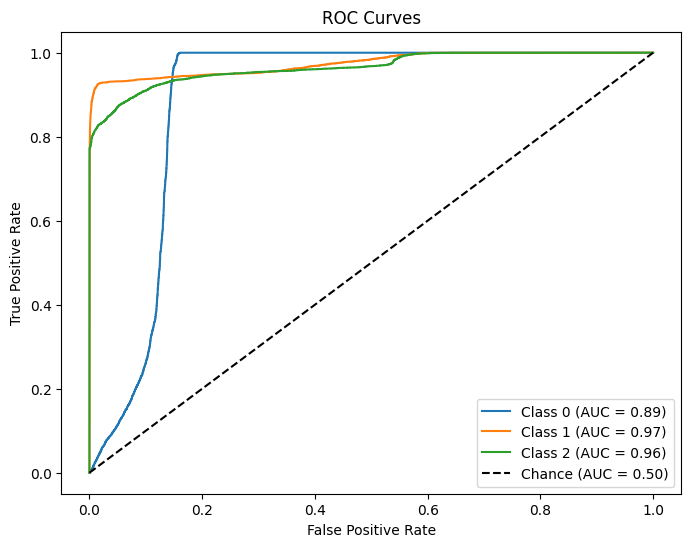

Average AUC: 0.9430


In [37]:
val_loss, avg_auc = evaluate_classifier(classifier_model, val_loader_cls, num_classes=3)
print(f"Average AUC: {avg_auc:.4f}")

In [38]:
torch.save(modelMAE.state_dict(), 'pretrained_mae_weights.pth')

In [39]:
base_path = "/content/datasetResolution/Dataset"
lr_dir = os.path.join(base_path, "LR")
hr_dir = os.path.join(base_path, "HR")
lr_paths = [os.path.join(lr_dir, f) for f in os.listdir(lr_dir) if f.endswith('.npy')]
hr_paths = [os.path.join(hr_dir, f) for f in os.listdir(hr_dir) if f.endswith('.npy')]
lr_paths.sort()
hr_paths.sort()

In [40]:
sr_dataset = SRDataset(lr_paths, hr_paths, transform=None)

In [41]:
train_size = int(0.8 * len(sr_dataset))
val_size = len(sr_dataset) - train_size
train_dataset, val_dataset = random_split(sr_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [42]:
pretrained_MAE = modelMAE
pretrained_MAE = pretrained_MAE.to(device)
pretrained_MAE.load_state_dict(torch.load('pretrained_mae_weights.pth'))
custom_encoder = CustomEncoder(pretrained_MAE)
sr_model = SRModel(pretrained_encoder=custom_encoder, target_size=(150,150)).to(device)

In [43]:
optimizer = optim.Adam(sr_model.parameters(), lr=1e-4)
scaler = torch.amp.GradScaler('cuda')
print("Starting Super-Resolution Fine-Tuning...")
train_sr(sr_model, train_loader, optimizer, device, scaler, epochs=10)

Starting Super-Resolution Fine-Tuning...


SR Training Epoch 1/10:   0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-19-b76c23cb6511>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
SR Training Epoch 1/10: 100%|██████████| 500/500 [00:19<00:00, 25.41it/s, loss=0.0009]


Epoch 1/10, SR Loss: 0.0302


SR Training Epoch 2/10: 100%|██████████| 500/500 [00:10<00:00, 45.95it/s, loss=0.0004]


Epoch 2/10, SR Loss: 0.0007


SR Training Epoch 3/10: 100%|██████████| 500/500 [00:09<00:00, 51.10it/s, loss=0.0003]


Epoch 3/10, SR Loss: 0.0004


SR Training Epoch 4/10: 100%|██████████| 500/500 [00:10<00:00, 48.54it/s, loss=0.0003]


Epoch 4/10, SR Loss: 0.0003


SR Training Epoch 5/10: 100%|██████████| 500/500 [00:10<00:00, 47.65it/s, loss=0.0003]


Epoch 5/10, SR Loss: 0.0003


SR Training Epoch 6/10: 100%|██████████| 500/500 [00:10<00:00, 47.18it/s, loss=0.0002]


Epoch 6/10, SR Loss: 0.0002


SR Training Epoch 7/10: 100%|██████████| 500/500 [00:15<00:00, 32.05it/s, loss=0.0002]


Epoch 7/10, SR Loss: 0.0002


SR Training Epoch 8/10: 100%|██████████| 500/500 [00:10<00:00, 46.84it/s, loss=0.0002]


Epoch 8/10, SR Loss: 0.0002


SR Training Epoch 9/10: 100%|██████████| 500/500 [00:10<00:00, 46.72it/s, loss=0.0001]


Epoch 9/10, SR Loss: 0.0002


SR Training Epoch 10/10: 100%|██████████| 500/500 [00:10<00:00, 48.55it/s, loss=0.0001]

Epoch 10/10, SR Loss: 0.0002


In [44]:
evaluate_sr(sr_model, val_loader, device)

Evaluating SR:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                                

SR Evaluation - MSE: 0.0001, PSNR: 38.43, SSIM: 0.9509


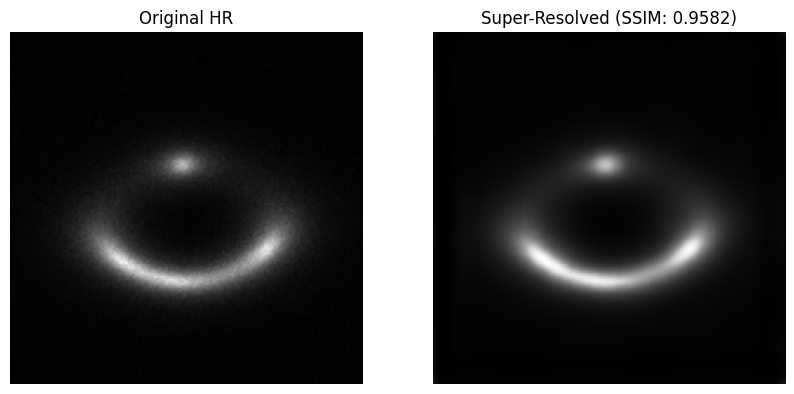

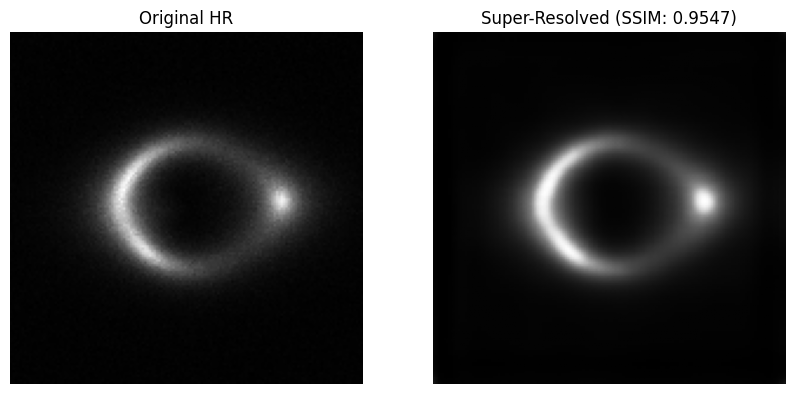

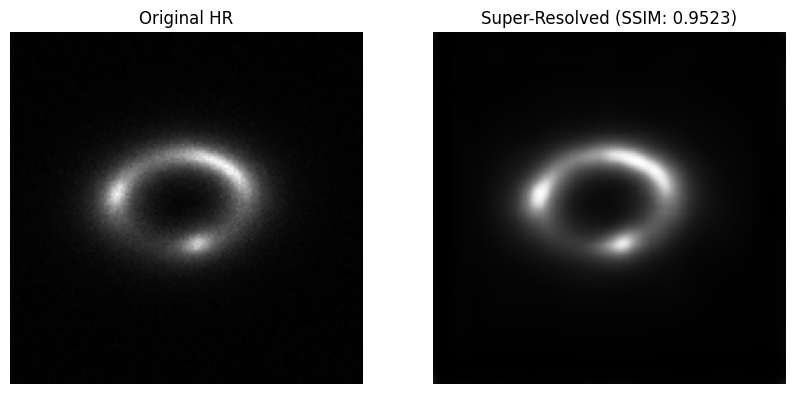

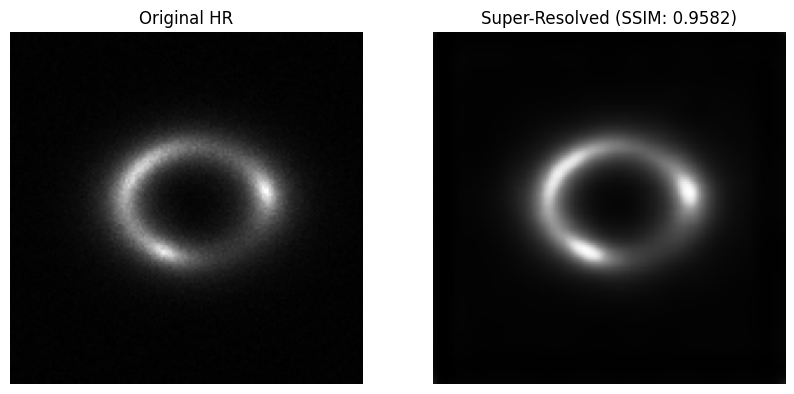

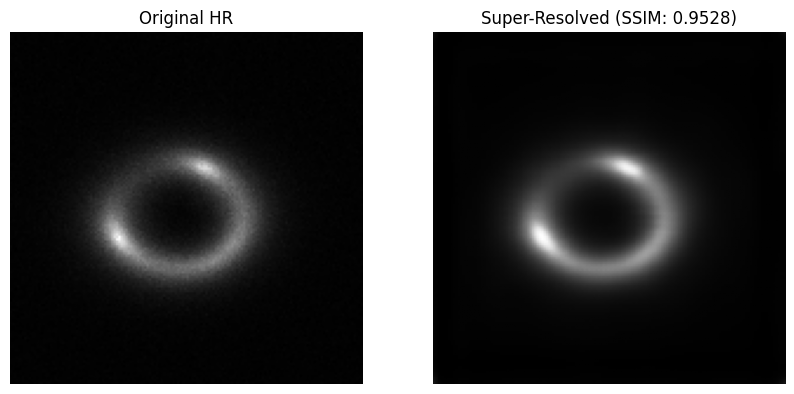

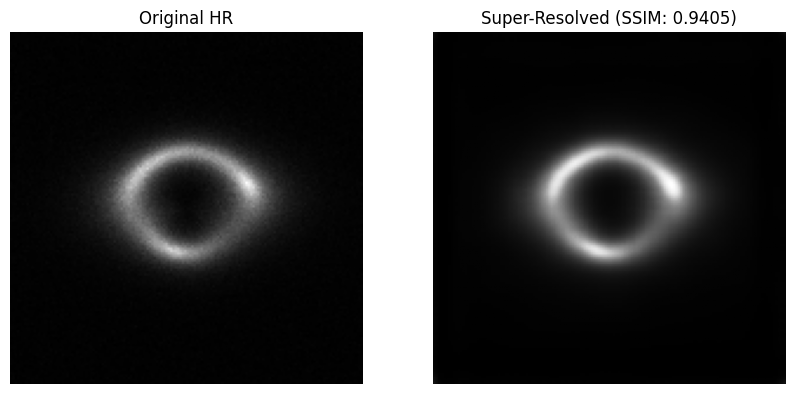

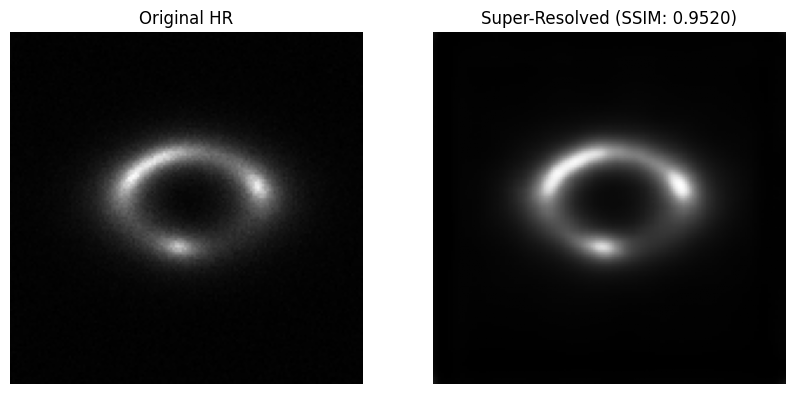

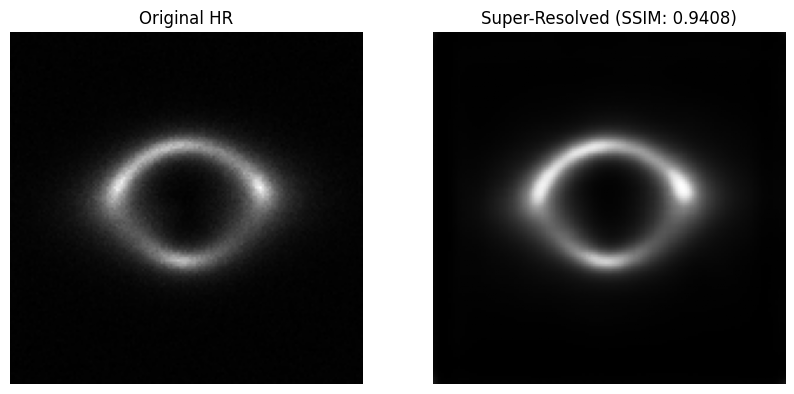

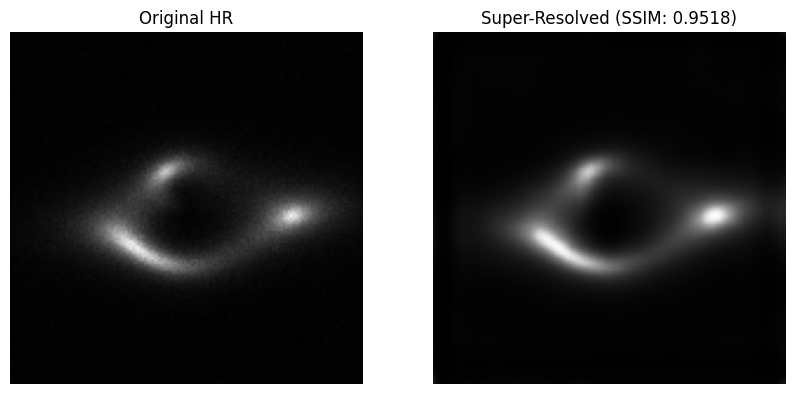

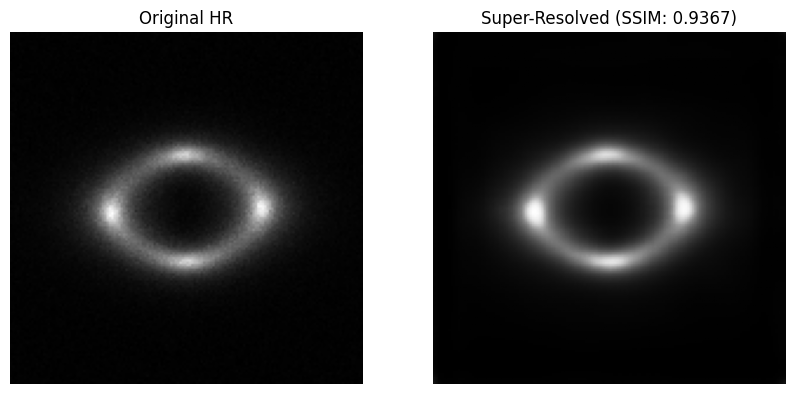

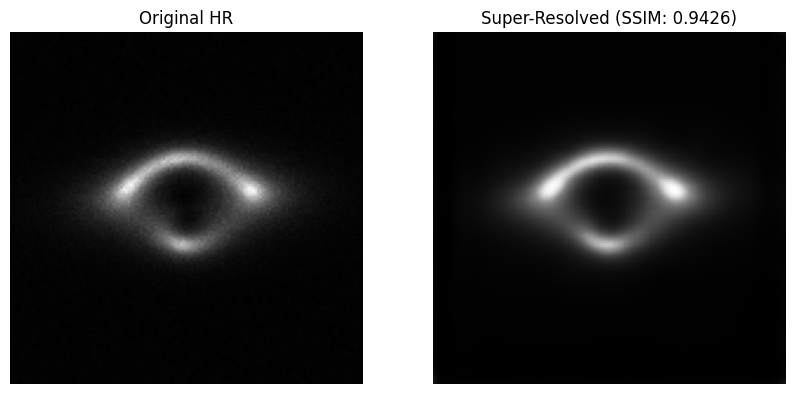

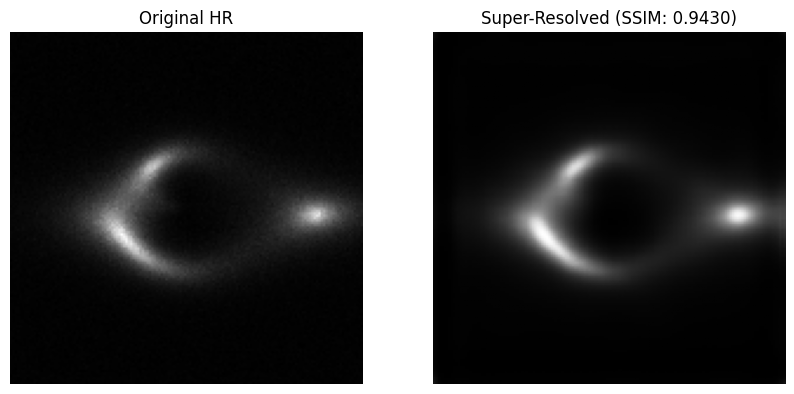

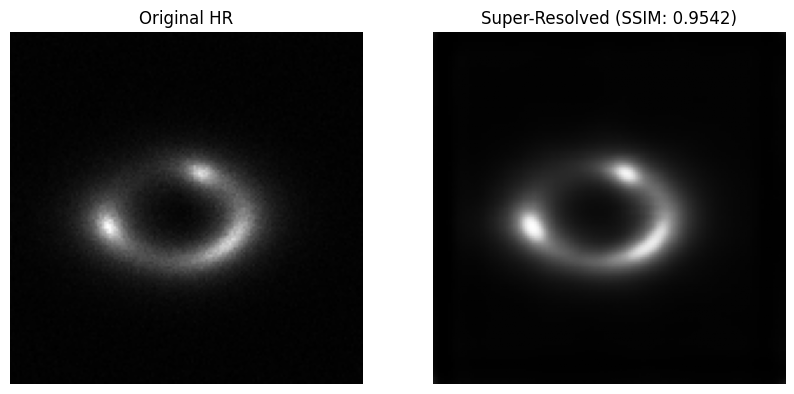

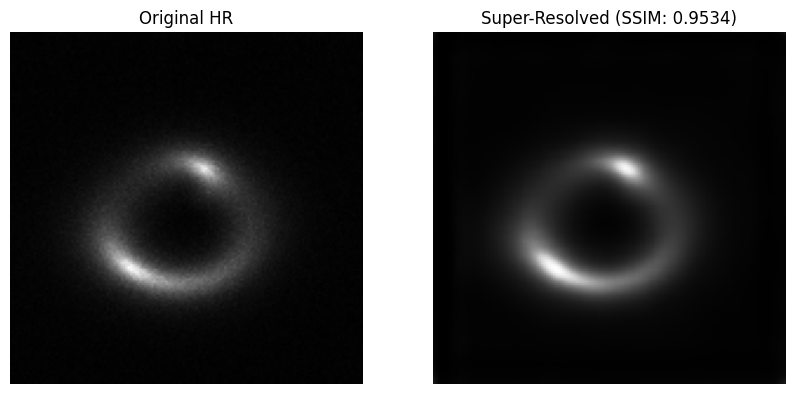

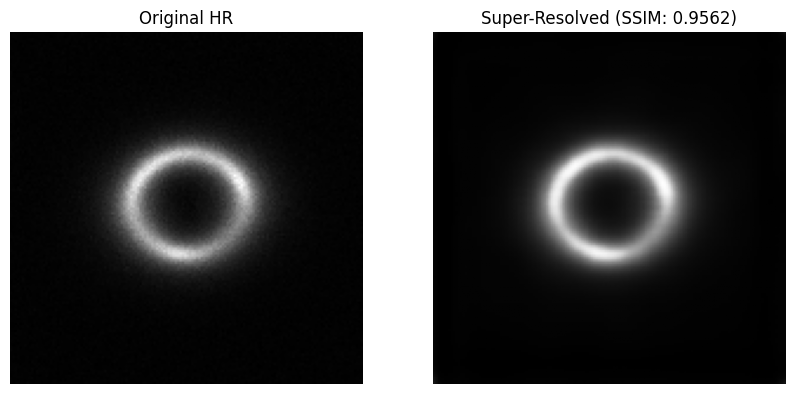

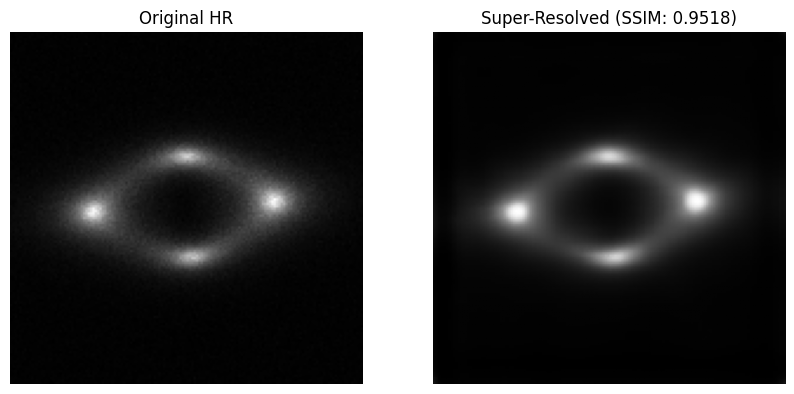

In [45]:
compare_hr_sr(sr_model, val_loader, device)